In [1]:
%load_ext autoreload
%autoreload 2
!pip install kornia==0.6.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install kornia_moons

In [3]:
!pip install pycolmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 16.7 MB/s eta 0:00:00


In [4]:
import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')

## Download example data

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


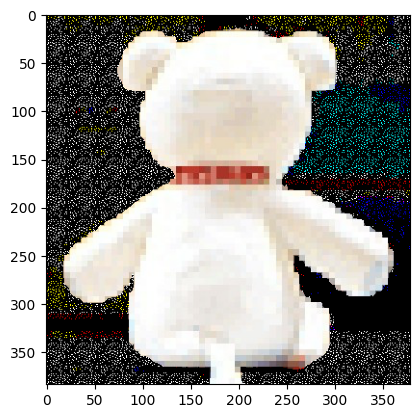

In [12]:
dirname = os.path.join('/content/drive/MyDrive/3 D reconstrcution test/dirname')
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.png' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## LoFTR Matching

In [13]:
def get_unique_idxs(A, dim=1):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout_loftr',
                   device=torch.device('cpu'),
                   min_matches=15, resize_to_ = (640, 480)):
    matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
    # First we do pairwise matching, and then extract "keypoints" from loftr matches

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            # Load img1
            timg1 = K.color.rgb_to_grayscale(load_torch_image(fname1, device=device))
            H1, W1 = timg1.shape[2:]
            if H1 < W1:
                resize_to = resize_to_[1], resize_to_[0]
            else:
                resize_to = resize_to_
            timg_resized1 = K.geometry.resize(timg1, resize_to, antialias=True)
            h1, w1 = timg_resized1.shape[2:]

            # Load img2
            timg2 = K.color.rgb_to_grayscale(load_torch_image(fname2, device=device))
            H2, W2 = timg2.shape[2:]
            if H2 < W2:
                resize_to2 = resize_to[1], resize_to[0]
            else:
                resize_to2 = resize_to_
            timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
            h2, w2 = timg_resized2.shape[2:]
            with torch.inference_mode():
                input_dict = {"image0": timg_resized1,"image1": timg_resized2}
                correspondences = matcher(input_dict)
            mkpts0 = correspondences['keypoints0'].cpu().numpy()
            mkpts1 = correspondences['keypoints1'].cpu().numpy()

            mkpts0[:,0] *= float(W1) / float(w1)
            mkpts0[:,1] *= float(H1) / float(h1)

            mkpts1[:,0] *= float(W2) / float(w2)
            mkpts1[:,1] *= float(H2) / float(h2)

            n_matches = len(mkpts1)
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))
    # Let's find unique loftr pixels and group them together
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts=defaultdict(int)
    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group  = f_match[k1]
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0]+=total_kpts[k1]
                current_match[:, 1]+=total_kpts[k2]
                total_kpts[k1]+=len(matches)
                total_kpts[k2]+=len(matches)
                match_indexes[k1][k2]=current_match
    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))
    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)
    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]),dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()
    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:,0] = unique_match_idxs[k1][m2[:,0]]
            m2[:,1] = unique_match_idxs[k2][m2[:,1]]
            mkpts = np.concatenate([unique_kpts[k1][ m2[:,0]],
                                    unique_kpts[k2][  m2[:,1]],
                                   ],
                                   axis=1)
            unique_idxs_current = get_unique_idxs(torch.from_numpy(mkpts), dim=0)
            m2_semiclean = m2[unique_idxs_current]
            unique_idxs_current1 = get_unique_idxs(m2_semiclean[:, 0], dim=0)
            m2_semiclean = m2_semiclean[unique_idxs_current1]
            unique_idxs_current2 = get_unique_idxs(m2_semiclean[:, 1], dim=0)
            m2_semiclean2 = m2_semiclean[unique_idxs_current2]
            out_match[k1][k2] = m2_semiclean2.numpy()
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1

    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group  = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match
    return



In [14]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [15]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('.featureout_loftr'):
    os.makedirs('.featureout_loftr')

feature_dir = '.featureout_loftr'

dev=torch.device('mps')
dev=torch.device('cpu')

In [16]:
match_features(img_fnames, index_pairs, feature_dir = feature_dir, device=dev)

In [19]:

import os, argparse, h5py, warnings
import numpy as np
from tqdm import tqdm
from PIL import Image, ExifTags

def get_focal(image_path, err_on_default=False):
    image         = Image.open(image_path)
    max_size      = max(image.size)

    exif = image.getexif()
    focal = None
    if exif is not None:
        focal_35mm = None
        # https://github.com/colmap/colmap/blob/d3a29e203ab69e91eda938d6e56e1c7339d62a99/src/util/bitmap.cc#L299
        for tag, value in exif.items():
            focal_35mm = None
            if ExifTags.TAGS.get(tag, None) == 'FocalLengthIn35mmFilm':
                focal_35mm = float(value)
                break

        if focal_35mm is not None:
            focal = focal_35mm / 35. * max_size

    if focal is None:
        if err_on_default:
            raise RuntimeError("Failed to find focal length")

        # failed to find it in exif, use prior
        FOCAL_PRIOR = 1.2
        focal = FOCAL_PRIOR * max_size

    return focal

def create_camera(db, image_path, camera_model):
    image         = Image.open(image_path)
    width, height = image.size

    focal = get_focal(image_path)

    if camera_model == 'simple-pinhole':
        model = 0 # simple pinhole
        param_arr = np.array([focal, width / 2, height / 2])
    if camera_model == 'pinhole':
        model = 1 # pinhole
        param_arr = np.array([focal, focal, width / 2, height / 2])
    elif camera_model == 'simple-radial':
        model = 2 # simple radial
        param_arr = np.array([focal, width / 2, height / 2, 0.1])
    elif camera_model == 'opencv':
        model = 4 # opencv
        param_arr = np.array([focal, focal, width / 2, height / 2, 0., 0., 0., 0.])

    return db.add_camera(model, width, height, param_arr)


def add_keypoints(db, h5_path, image_path, img_ext, camera_model, single_camera = True):
    keypoint_f = h5py.File(os.path.join(h5_path, 'keypoints.h5'), 'r')

    camera_id = None
    fname_to_id = {}
    for filename in tqdm(list(keypoint_f.keys())):
        keypoints = keypoint_f[filename][()]

        fname_with_ext = filename# + img_ext
        path = os.path.join(image_path, fname_with_ext)
        if not os.path.isfile(path):
            raise IOError(f'Invalid image path {path}')

        if camera_id is None or not single_camera:
            camera_id = create_camera(db, path, camera_model)
        image_id = db.add_image(fname_with_ext, camera_id)
        fname_to_id[filename] = image_id

        db.add_keypoints(image_id, keypoints)

    return fname_to_id

def add_matches(db, h5_path, fname_to_id):
    match_file = h5py.File(os.path.join(h5_path, 'matches.h5'), 'r')

    added = set()
    n_keys = len(match_file.keys())
    n_total = (n_keys * (n_keys - 1)) // 2

    with tqdm(total=n_total) as pbar:
        for key_1 in match_file.keys():
            group = match_file[key_1]
            for key_2 in group.keys():
                id_1 = fname_to_id[key_1]
                id_2 = fname_to_id[key_2]

                pair_id = image_ids_to_pair_id(id_1, id_2)
                if pair_id in added:
                    warnings.warn(f'Pair {pair_id} ({id_1}, {id_2}) already added!')
                    continue

                matches = group[key_2][()]
                db.add_matches(id_1, id_2, matches)

                added.add(pair_id)

                pbar.update(1)

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

In [20]:
import sys
import sqlite3
import numpy as np


IS_PYTHON3 = sys.version_info[0] >= 3

MAX_IMAGE_ID = 2**31 - 1

CREATE_CAMERAS_TABLE = """CREATE TABLE IF NOT EXISTS cameras (
    camera_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    model INTEGER NOT NULL,
    width INTEGER NOT NULL,
    height INTEGER NOT NULL,
    params BLOB,
    prior_focal_length INTEGER NOT NULL)"""

CREATE_DESCRIPTORS_TABLE = """CREATE TABLE IF NOT EXISTS descriptors (
    image_id INTEGER PRIMARY KEY NOT NULL,
    rows INTEGER NOT NULL,
    cols INTEGER NOT NULL,
    data BLOB,
    FOREIGN KEY(image_id) REFERENCES images(image_id) ON DELETE CASCADE)"""

CREATE_IMAGES_TABLE = """CREATE TABLE IF NOT EXISTS images (
    image_id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    name TEXT NOT NULL UNIQUE,
    camera_id INTEGER NOT NULL,
    prior_qw REAL,
    prior_qx REAL,
    prior_qy REAL,
    prior_qz REAL,
    prior_tx REAL,
    prior_ty REAL,
    prior_tz REAL,
    CONSTRAINT image_id_check CHECK(image_id >= 0 and image_id < {}),
    FOREIGN KEY(camera_id) REFERENCES cameras(camera_id))
""".format(MAX_IMAGE_ID)

CREATE_TWO_VIEW_GEOMETRIES_TABLE = """
CREATE TABLE IF NOT EXISTS two_view_geometries (
    pair_id INTEGER PRIMARY KEY NOT NULL,
    rows INTEGER NOT NULL,
    cols INTEGER NOT NULL,
    data BLOB,
    config INTEGER NOT NULL,
    F BLOB,
    E BLOB,
    H BLOB)
"""

CREATE_KEYPOINTS_TABLE = """CREATE TABLE IF NOT EXISTS keypoints (
    image_id INTEGER PRIMARY KEY NOT NULL,
    rows INTEGER NOT NULL,
    cols INTEGER NOT NULL,
    data BLOB,
    FOREIGN KEY(image_id) REFERENCES images(image_id) ON DELETE CASCADE)
"""

CREATE_MATCHES_TABLE = """CREATE TABLE IF NOT EXISTS matches (
    pair_id INTEGER PRIMARY KEY NOT NULL,
    rows INTEGER NOT NULL,
    cols INTEGER NOT NULL,
    data BLOB)"""

CREATE_NAME_INDEX = \
    "CREATE UNIQUE INDEX IF NOT EXISTS index_name ON images(name)"

CREATE_ALL = "; ".join([
    CREATE_CAMERAS_TABLE,
    CREATE_IMAGES_TABLE,
    CREATE_KEYPOINTS_TABLE,
    CREATE_DESCRIPTORS_TABLE,
    CREATE_MATCHES_TABLE,
    CREATE_TWO_VIEW_GEOMETRIES_TABLE,
    CREATE_NAME_INDEX
])


def image_ids_to_pair_id(image_id1, image_id2):
    if image_id1 > image_id2:
        image_id1, image_id2 = image_id2, image_id1
    return image_id1 * MAX_IMAGE_ID + image_id2


def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2


def array_to_blob(array):
    if IS_PYTHON3:
        return array.tostring()
    else:
        return np.getbuffer(array)


def blob_to_array(blob, dtype, shape=(-1,)):
    if IS_PYTHON3:
        return np.fromstring(blob, dtype=dtype).reshape(*shape)
    else:
        return np.frombuffer(blob, dtype=dtype).reshape(*shape)


class COLMAPDatabase(sqlite3.Connection):

    @staticmethod
    def connect(database_path):
        return sqlite3.connect(database_path, factory=COLMAPDatabase)


    def __init__(self, *args, **kwargs):
        super(COLMAPDatabase, self).__init__(*args, **kwargs)

        self.create_tables = lambda: self.executescript(CREATE_ALL)
        self.create_cameras_table = \
            lambda: self.executescript(CREATE_CAMERAS_TABLE)
        self.create_descriptors_table = \
            lambda: self.executescript(CREATE_DESCRIPTORS_TABLE)
        self.create_images_table = \
            lambda: self.executescript(CREATE_IMAGES_TABLE)
        self.create_two_view_geometries_table = \
            lambda: self.executescript(CREATE_TWO_VIEW_GEOMETRIES_TABLE)
        self.create_keypoints_table = \
            lambda: self.executescript(CREATE_KEYPOINTS_TABLE)
        self.create_matches_table = \
            lambda: self.executescript(CREATE_MATCHES_TABLE)
        self.create_name_index = lambda: self.executescript(CREATE_NAME_INDEX)

    def add_camera(self, model, width, height, params,
                   prior_focal_length=False, camera_id=None):
        params = np.asarray(params, np.float64)
        cursor = self.execute(
            "INSERT INTO cameras VALUES (?, ?, ?, ?, ?, ?)",
            (camera_id, model, width, height, array_to_blob(params),
             prior_focal_length))
        return cursor.lastrowid

    def add_image(self, name, camera_id,
                  prior_q=np.zeros(4), prior_t=np.zeros(3), image_id=None):
        cursor = self.execute(
            "INSERT INTO images VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
            (image_id, name, camera_id, prior_q[0], prior_q[1], prior_q[2],
             prior_q[3], prior_t[0], prior_t[1], prior_t[2]))
        return cursor.lastrowid

    def add_keypoints(self, image_id, keypoints):
        assert(len(keypoints.shape) == 2)
        assert(keypoints.shape[1] in [2, 4, 6])

        keypoints = np.asarray(keypoints, np.float32)
        self.execute(
            "INSERT INTO keypoints VALUES (?, ?, ?, ?)",
            (image_id,) + keypoints.shape + (array_to_blob(keypoints),))

    def add_descriptors(self, image_id, descriptors):
        descriptors = np.ascontiguousarray(descriptors, np.uint8)
        self.execute(
            "INSERT INTO descriptors VALUES (?, ?, ?, ?)",
            (image_id,) + descriptors.shape + (array_to_blob(descriptors),))

    def add_matches(self, image_id1, image_id2, matches):
        assert(len(matches.shape) == 2)
        assert(matches.shape[1] == 2)

        if image_id1 > image_id2:
            matches = matches[:,::-1]

        pair_id = image_ids_to_pair_id(image_id1, image_id2)
        matches = np.asarray(matches, np.uint32)
        self.execute(
            "INSERT INTO matches VALUES (?, ?, ?, ?)",
            (pair_id,) + matches.shape + (array_to_blob(matches),))

    def add_two_view_geometry(self, image_id1, image_id2, matches,
                              F=np.eye(3), E=np.eye(3), H=np.eye(3), config=2):
        assert(len(matches.shape) == 2)
        assert(matches.shape[1] == 2)

        if image_id1 > image_id2:
            matches = matches[:,::-1]

        pair_id = image_ids_to_pair_id(image_id1, image_id2)
        matches = np.asarray(matches, np.uint32)
        F = np.asarray(F, dtype=np.float64)
        E = np.asarray(E, dtype=np.float64)
        H = np.asarray(H, dtype=np.float64)
        self.execute(
            "INSERT INTO two_view_geometries VALUES (?, ?, ?, ?, ?, ?, ?, ?)",
            (pair_id,) + matches.shape + (array_to_blob(matches), config,
             array_to_blob(F), array_to_blob(E), array_to_blob(H)))


def example_usage():
    import os
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--database_path", default="database.db")
    args = parser.parse_args()

    if os.path.exists(args.database_path):
        print("ERROR: database path already exists -- will not modify it.")
        return

    # Open the database.

    db = COLMAPDatabase.connect(args.database_path)

    # For convenience, try creating all the tables upfront.

    db.create_tables()

    # Create dummy cameras.

    model1, width1, height1, params1 = \
        0, 1024, 768, np.array((1024., 512., 384.))
    model2, width2, height2, params2 = \
        2, 1024, 768, np.array((1024., 512., 384., 0.1))

    camera_id1 = db.add_camera(model1, width1, height1, params1)
    camera_id2 = db.add_camera(model2, width2, height2, params2)

    # Create dummy images.

    image_id1 = db.add_image("image1.png", camera_id1)
    image_id2 = db.add_image("image2.png", camera_id1)
    image_id3 = db.add_image("image3.png", camera_id2)
    image_id4 = db.add_image("image4.png", camera_id2)

    # Create dummy keypoints.
    #
    # Note that COLMAP supports:
    #      - 2D keypoints: (x, y)
    #      - 4D keypoints: (x, y, theta, scale)
    #      - 6D affine keypoints: (x, y, a_11, a_12, a_21, a_22)

    num_keypoints = 1000
    keypoints1 = np.random.rand(num_keypoints, 2) * (width1, height1)
    keypoints2 = np.random.rand(num_keypoints, 2) * (width1, height1)
    keypoints3 = np.random.rand(num_keypoints, 2) * (width2, height2)
    keypoints4 = np.random.rand(num_keypoints, 2) * (width2, height2)

    db.add_keypoints(image_id1, keypoints1)
    db.add_keypoints(image_id2, keypoints2)
    db.add_keypoints(image_id3, keypoints3)
    db.add_keypoints(image_id4, keypoints4)

    # Create dummy matches.

    M = 50
    matches12 = np.random.randint(num_keypoints, size=(M, 2))
    matches23 = np.random.randint(num_keypoints, size=(M, 2))
    matches34 = np.random.randint(num_keypoints, size=(M, 2))

    db.add_matches(image_id1, image_id2, matches12)
    db.add_matches(image_id2, image_id3, matches23)
    db.add_matches(image_id3, image_id4, matches34)

    # Commit the data to the file.

    db.commit()

    # Read and check cameras.

    rows = db.execute("SELECT * FROM cameras")

    camera_id, model, width, height, params, prior = next(rows)
    params = blob_to_array(params, np.float64)
    assert camera_id == camera_id1
    assert model == model1 and width == width1 and height == height1
    assert np.allclose(params, params1)

    camera_id, model, width, height, params, prior = next(rows)
    params = blob_to_array(params, np.float64)
    assert camera_id == camera_id2
    assert model == model2 and width == width2 and height == height2
    assert np.allclose(params, params2)

    # Read and check keypoints.

    keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

    assert np.allclose(keypoints[image_id1], keypoints1)
    assert np.allclose(keypoints[image_id2], keypoints2)
    assert np.allclose(keypoints[image_id3], keypoints3)
    assert np.allclose(keypoints[image_id4], keypoints4)

    # Read and check matches.

    pair_ids = [image_ids_to_pair_id(*pair) for pair in
                ((image_id1, image_id2),
                 (image_id2, image_id3),
                 (image_id3, image_id4))]

    matches = dict(
        (pair_id_to_image_ids(pair_id),
         blob_to_array(data, np.uint32, (-1, 2)))
        for pair_id, data in db.execute("SELECT pair_id, data FROM matches")
    )

    assert np.all(matches[(image_id1, image_id2)] == matches12)
    assert np.all(matches[(image_id2, image_id3)] == matches23)
    assert np.all(matches[(image_id3, image_id4)] == matches34)

    # Clean up.

    db.close()

    if os.path.exists(args.database_path):
        os.remove(args.database_path)


In [22]:
!ls

keypoints.h5  matches.h5  matches_loftr.h5


In [27]:

from google.colab import files

files.download('keypoints.h5')
files.download('matches.h5')
files.download('matches_loftr.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>